<a href="https://colab.research.google.com/github/mairegrant/fireClassification/blob/main/Fire_Classification_Arson_Accidental.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install split-folders

import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import zipfile
from google.colab import drive

#drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
ZIP_PATH = 'ZIP_PATH'
UNZIP_PATH = 'UNZIP_PATH'

print("Extracting data...")
with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall(UNZIP_PATH)

print("Extraction complete.")

Extracting data...
Extraction complete.


In [3]:
# Define paths based on where you unzipped the data
BASE_DATA_DIR = os.path.join(UNZIP_PATH, 'fire_classification_data')
TRAIN_DIR = os.path.join(BASE_DATA_DIR, 'train')
VAL_DIR = os.path.join(BASE_DATA_DIR, 'validation')

# Standard size for many Transfer Learning models (like ResNet50)
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [4]:
from PIL import Image
import os

# Define the root directory where your 'train', 'validation', and 'test' folders are
ROOT_DIR = '/content/fire_classification_data/'

TARGET_FORMAT = 'JPEG'
TARGET_EXTENSION = '.jpg'

print("Starting image conversion...")

# Loop through all folders (train, validation, test) and subfolders (accidental, arson)
for root, _, files in os.walk(ROOT_DIR):
    for file in files:
        if file.endswith(('.png', '.jpeg', '.bmp', '.gif')) and not file.endswith(TARGET_EXTENSION):

            old_path = os.path.join(root, file)

            # Create the new filename with the target extension
            base_name, _ = os.path.splitext(file)
            new_path = os.path.join(root, base_name + TARGET_EXTENSION)

            try:
                img = Image.open(old_path).convert('RGB')
                img.save(new_path, format=TARGET_FORMAT)
                os.remove(old_path)

            except Exception as e:
                print(f"Error converting {old_path}: {e}")

print("Image conversion complete. All files should now be .jpg.")

Starting image conversion...
Image conversion complete. All files should now be .jpg.


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Training Generator (Includes Augmentation and Rescaling)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# 2. Validation Generator (Only Rescaling - NO Augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow from Directory to create the iterators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Output should confirm 2 classes found (accidental, arson)
print("Class Indices:", train_generator.class_indices)
NUM_CLASSES = len(train_generator.class_indices)

Found 32 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
Class Indices: {'accidental': 0, 'arson': 1}


In [6]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

# Load ResNet50 pre-trained on ImageNet, excluding the final classification layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model so their weights aren't updated during initial training
base_model.trainable = False

# Create the head of the model for our custom classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x) # Dropout to help prevent overfitting
predictions = Dense(NUM_CLASSES, activation='softmax')(x) # Final classification layer (2 outputs)

# Combine the base model and the new head
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,687,938 (97.99 MB)

 Trainable params: 2,100,226 (8.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [7]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
EPOCHS = 30 # Start with a small number of epochs
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step - accuracy: 0.6562 - loss: 0.7059 - val_accuracy: 0.7000 - val_loss: 0.6163
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6562 - loss: 0.7214 - val_accuracy: 0.7000 - val_loss: 0.6167
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6562 - loss: 0.7687 - val_accuracy: 0.7000 - val_loss: 0.6260
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7188 - loss: 0.5767 - val_accuracy: 0.7000 - val_loss: 0.6260
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6250 - loss: 0.7704 - val_accuracy: 0.7000 - val_loss: 0.6256
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6250 - loss: 0.7207 - val_accuracy: 0.7000 - val_loss: 0.6254
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6250 - loss: 0.7029 - val_accuracy: 0.7000 - val_loss: 0.6238
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5625 - loss: 0.6253 - val_accuracy: 0.7000 - val_loss: 0.6229
Epoch 9/30
1/1

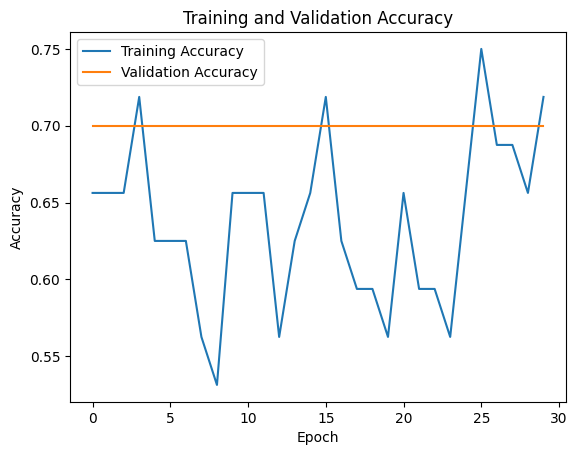

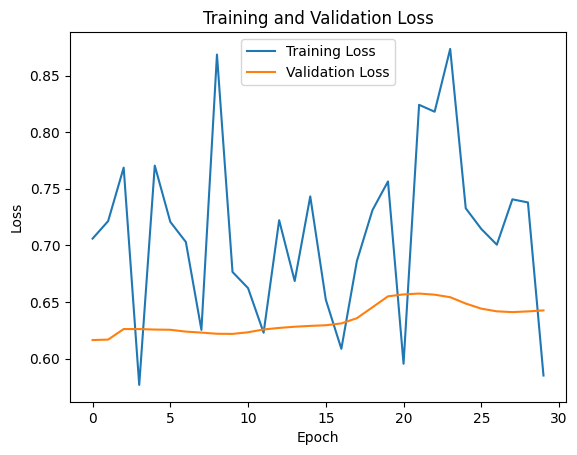

In [8]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image
import os

# --- 1. Define Image Path ---
# NOTE: Make sure the file extension in IMG_PATH matches the actual file you uploaded
# (e.g., if you uploaded a PNG, keep the .png extension here temporarily).
IMG_PATH = 'INPUT_IMAGE_PATH'

# Define a temporary path for the converted JPEG file
TEMP_JPG_PATH = 'TEMP_IMG_PATH'

# --- 2. Conversion and Preprocessing ---
IMG_SIZE = (224, 224)

try:
    # 2a. Convert to JPEG using PIL
    img_pil = Image.open(IMG_PATH).convert('RGB')
    img_pil.save(TEMP_JPG_PATH, format='JPEG')

    print(f"Image successfully converted and saved as {TEMP_JPG_PATH}")

    # 2b. Load the newly converted JPEG file and resize it
    img = image.load_img(TEMP_JPG_PATH, target_size=IMG_SIZE)

    # 2c. Convert to a NumPy array
    img_array = image.img_to_array(img)

    # Add a dimension (1, 224, 224, 3) for the batch size
    img_array = np.expand_dims(img_array, axis=0)

    # Rescale pixel values (Normalization)
    img_array /= 255.0

    print("Image loaded and preprocessed successfully.")

except FileNotFoundError:
    print(f"Error: Image not found at the initial path: {IMG_PATH}. Please check the path.")

except Exception as e:
    print(f"An error occurred during loading/conversion: {e}")


Image successfully converted and saved as /content/temp_test_image.jpg
Image loaded and preprocessed successfully.


In [12]:
# --- 1. Make the Prediction ---
# The prediction returns the probability distribution across all classes
predictions = model.predict(img_array)

# --- 2. Get the Predicted Class and Probability ---
# np.argmax finds the index (0 or 1) with the highest probability
predicted_class_index = np.argmax(predictions[0])
confidence = predictions[0][predicted_class_index]

# --- 3. Map Index to Class Name ---
# You must use the class indices found in Step 7: {'accidental': 0, 'arson': 1}
class_names = list(train_generator.class_indices.keys())
predicted_label = class_names[predicted_class_index]

# --- 4. Display Results ---
print("-" * 40)
print(f"The model predicts this image is: **{predicted_label.upper()}**")
print(f"Confidence (Probability): {confidence * 100:.2f}%")
print("-" * 40)

print("Raw Probabilities (Accidental, Arson):", predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
----------------------------------------
The model predicts this image is: **ACCIDENTAL**
Confidence (Probability): 71.78%
----------------------------------------
Raw Probabilities (Accidental, Arson): [0.71782273 0.2821772 ]
